['deflection_spec forward', 'z-axis sensor_spec forward', 'deflection_spec backward', 'z-axis sensor_spec backward', 'tip-sample separation_indentationzsensorfwd0', 'tip-sample separation_indentationzsensorbwd0', 'deflection_indentationdeflfwd0', 'deflection_indentationdeflbwd0', 'namez4_slopeout00', 'namez5_slopeout10', 'namez6_slopeout20', 'namez7_maxadhesionout00', 'namez8_maxadhesionout10', 'namez9_slopeout01', 'namez10_slopeout11', 'namez11_slopeout21', 'namez12_snapinout00', 'namez13_snapinout10', 'deflection_scan forward', 'z-axis_scan forward', 'z-axis sensor_scan forward', 'deflection_scan backward', 'z-axis_scan backward', 'z-axis sensor_scan backward']
['DataSet', 'DataSet-Info', 'DataSet\\DataSetInfos', 'DataSet\\DataSetInfos\\Spec', 'DataSet\\DataSetInfos\\Scan', 'DataSet\\DataSetInfos\\Feedback', 'DataSet\\DataSetInfos\\Module', 'DataSet\\DataSetInfos\\Global', 'DataSet\\Calibration', 'DataSet\\Calibration\\Scanhead', 'DataSet\\Calibration\\Cantilever', 'DataSet\\Paramete

Text(0, 0.5, 'Deflection (nm)')

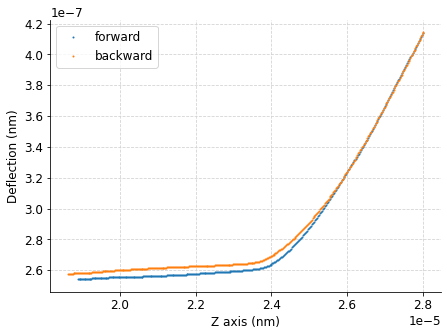

In [1]:
#%%
from pathlib import Path
import mmap
from configparser import ConfigParser, SectionProxy
import re

import numpy as np


def get_dataset_sections(config: ConfigParser):
    section_regex = re.compile("DataSet-\d+:\d+")
    return filter(
        lambda name: re.match(section_regex, name) is not None, config.sections()
    )


def get_dtype(config: ConfigParser, name: str) -> np.dtype:
    section = config[name]
    assert (
        section["SaveMode"] == "Binary"
    ), "Reading non-binary data format is not supported!"
    endian = "<" if section["SaveOrder"] == "Intel" else ">"
    data_format = "i" if section["SaveSign"] == "Signed" else "u"
    num_bytes = int(section["SaveBits"]) // 8
    return np.dtype(f"{endian}{data_format}{num_bytes}")


def get_read_shape(config: ConfigParser, name: str) -> tuple[int, int]:
    section = config[name]
    dim0, dim1 = section["Points"], section["Lines"]
    return (int(dim0), int(dim1))


def get_scale_params(config: ConfigParser, name: str) -> tuple[float, float]:
    section = config[name]
    range_, offset = section["Dim2Range"], section["Dim2Min"]
    return float(range_), float(offset)


def get_read_length(shape: tuple[int, int], dtype: np.dtype) -> int:
    return shape[0] * shape[1] * dtype.itemsize


def scale_data(data: np.ndarray, datarange: float, dataoffset: float) -> np.ndarray:
    min_val = np.iinfo(data.dtype).min
    normalized_data = 1.0 + data / np.abs(min_val)
    return normalized_data * datarange + dataoffset


def get_data_name(config: ConfigParser, name: str) -> str:
    section = config[name]
    name, frame = section["Dim2Name"], section["Frame"]
    return f"{name.lower()}_{frame.lower()}"


def read_nid(filepath: str | Path):
    config_parser = ConfigParser(allow_no_value=True)
    with open(filepath, "rb") as file:
        with mmap.mmap(file.fileno(), length=0, access=mmap.ACCESS_READ) as memorymap:
            data_start_ind = memorymap.find(b"#!")
            header = memorymap[:data_start_ind].decode()
            config_list = header.split("\r\n")
            config_parser.read_file(config_list)

            shapes = [
                get_read_shape(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            dtypes = [
                get_dtype(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            read_lengths = [get_read_length(s, d) for s, d in zip(shapes, dtypes)]

            memorymap.seek(data_start_ind + 2)
            raw_data = [
                np.frombuffer(memorymap.read(n), d)
                for n, d in zip(read_lengths, dtypes)
            ]
            scale_params = [
                get_scale_params(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            data = [
                scale_data(raw, *p).reshape(s)
                for raw, p, s in zip(raw_data, scale_params, shapes)
            ]
            names = [
                get_data_name(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]

    return config_parser, dict(zip(names, data))


#%%
file = "../../data/afm/20230106/highly entangled hydrogel(C=1.0)/Image00801.nid"
config, data = read_nid(file)
print(list(data.keys()))
print(list(config.sections()))
#%%
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font", size=12)
matplotlib.rc("axes", grid=True)
matplotlib.rc("axes.spines", top=False, right=False)
matplotlib.rc("grid", linestyle="--", color="lightgray")


fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
for mode in ("forward", "backward"):
    ax.plot(
        data[f"z-axis sensor_spec {mode}"],
        data[f"deflection_spec {mode}"],
        ".",
        markersize=2,
        label=mode,
    )
ax.legend()
ax.set_xlabel("Z axis (nm)")
ax.set_ylabel("Deflection (nm)")

In [2]:
# Hertzian Curve Fitting
'''
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator, DataGenerator as dg

zf = data["z-axis sensor_spec forward"].reshape(-1)
df = data["deflection_spec forward"].reshape(-1)
zb = data["z-axis sensor_spec backward"].reshape(-1)
db = data["deflection_spec backward"].reshape(-1)

# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating
zf = zf - df
zb = zb - db

# Find the kneepoint 
klf = KneeLocator(zf,df, curve="convex")
klb = KneeLocator(zb, db, curve="convex")
klf.plot_knee()
klb.plot_knee()
kpf = klf.knee
kpb = klb.knee

# Move to origin
num_zf = len(zf)
num_zb = len(zb)

zf = np.delete(zf, np.where(zf<kpf))
zb = np.delete(zb, np.where(zb<kpb))
df = np.delete(df, np.where(df<df[num_zf-len(zf)]))
db = np.delete(db, np.where(db<db[num_zb-len(zb)]))

lf = len(zf)
lb = len(zb)

for i in range(1,lf):
    zf[i] = np.log(zf[i] - zf[0])
    df[i] = np.log(df[i] - df[0])

for i in range(1,lb):
    zb[i] = np.log(zb[i] - zb[0])
    db[i] = np.log(db[i] - db[0])

fig, ax = plt.subplots(1, 1)   

ax.plot(zf, df, "o-", color = "red", label = 'forward')
ax.plot(zb, db, "o-", color = "blue", label = 'backward')
ax.set_xlabel('Z-axis(nm)')
ax.set_ylabel('Deflection(nm)')
ax.set_title('AFM indentation test')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()

# least square fitting
a11 = 0
a12 = 0
b1 = 0
b2 = 0

for i in range(1,lf):
    a11 += zf[i]*zf[i]
    a12 += zf[i]
    b1 += zf[i]*df[i]
    b2 += df[i]

a21 = a12
a22 = lf -1

af = (a22*b1-a12*b2)/(a11*a22-a12*a21)
bf = (a11*b2-a21*b1)/(a11*a22-a12*a21)

for i in range(1,lb):
    a11 += zb[i]*zb[i]
    a12 += zb[i]
    b1 += zb[i]*db[i]
    b2 += db[i]
a21 = a12
a22 = lb -1

ab = (a22*b1-a12*b2)/(a11*a22-a12*a21)
bb = (a11*b2-a21*b1)/(a11*a22-a12*a21)

print(af, bf, ab, bb)

x = range(1,50)
yf = af*pow(x,bf)
yb = ab*pow(x,bb)

fig, ax = plt.subplots(1, 1)   

ax.plot(yf, "o-", color = "red", label = 'forward')
ax.plot(yb, "o-", color = "blue", label = 'backward')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('y=ax^b')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()
'''

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom kneed import KneeLocator, DataGenerator as dg\n\nzf = data["z-axis sensor_spec forward"].reshape(-1)\ndf = data["deflection_spec forward"].reshape(-1)\nzb = data["z-axis sensor_spec backward"].reshape(-1)\ndb = data["deflection_spec backward"].reshape(-1)\n\n# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating\nzf = zf - df\nzb = zb - db\n\n# Find the kneepoint \nklf = KneeLocator(zf,df, curve="convex")\nklb = KneeLocator(zb, db, curve="convex")\nklf.plot_knee()\nklb.plot_knee()\nkpf = klf.knee\nkpb = klb.knee\n\n# Move to origin\nnum_zf = len(zf)\nnum_zb = len(zb)\n\nzf = np.delete(zf, np.where(zf<kpf))\nzb = np.delete(zb, np.where(zb<kpb))\ndf = np.delete(df, np.where(df<df[num_zf-len(zf)]))\ndb = np.delete(db, np.where(db<db[num_zb-len(zb)]))\n\nlf = len(zf)\nlb = len(zb)\n\nfor i in range(1,lf):\n    zf[i] = np.log(zf[i] - zf[0])\n    df[i] = np.log(df[i] - df[0])\n\nfor i in range(1,lb):\n    zb[i] 

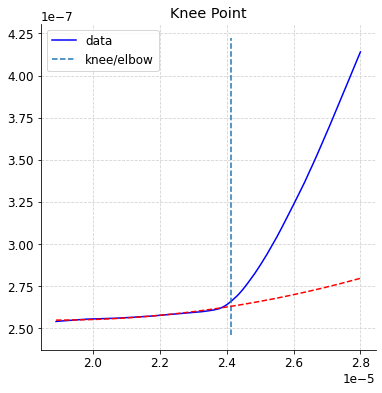

In [3]:
### Data Processing
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator, DataGenerator as dg

## Approach
deflection_f = np.array([])
deflection_f = np.append(deflection_f, data["deflection_spec forward"].reshape(-1))

z_axis_sensor_f = np.array([])
z_axis_sensor_f = np.append(z_axis_sensor_f, data["z-axis sensor_spec forward"].reshape(-1))

# Find the kneepoint forward
knee_f = KneeLocator(z_axis_sensor_f, deflection_f, curve="convex")
knee_f.plot_knee()
knee_point_f = knee_f.knee

z_axis_sensor_fk = np.delete(z_axis_sensor_f, np.where(z_axis_sensor_f>knee_point_f))
deflection_fk  = deflection_f[:len(z_axis_sensor_fk)]

fitting_f = np.poly1d(np.polyfit(z_axis_sensor_fk, deflection_fk, 2))
plt.plot(z_axis_sensor_f, fitting_f(z_axis_sensor_f), '--', color='red')

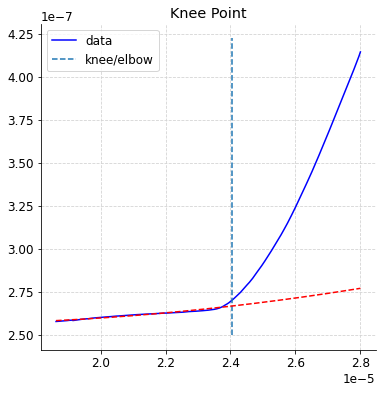

In [4]:
## Retraction
deflection_b = np.array([])
deflection_b = np.append(deflection_b, data["deflection_spec backward"].reshape(-1))

z_axis_sensor_b = np.array([])
z_axis_sensor_b = np.append(z_axis_sensor_b, data["z-axis sensor_spec backward"].reshape(-1))

# Find the kneepoint backward
knee_b = KneeLocator(z_axis_sensor_b, deflection_b, curve="convex")
knee_b.plot_knee()
knee_point_b = knee_b.knee

z_axis_sensor_bk = np.delete(z_axis_sensor_b, np.where(z_axis_sensor_b>knee_point_b))
deflection_bk  = deflection_b[:len(z_axis_sensor_bk)]

fitting_b = np.poly1d(np.polyfit(z_axis_sensor_bk, deflection_bk, 2))
plt.plot(z_axis_sensor_b, fitting_b(z_axis_sensor_b), '--', color='red')

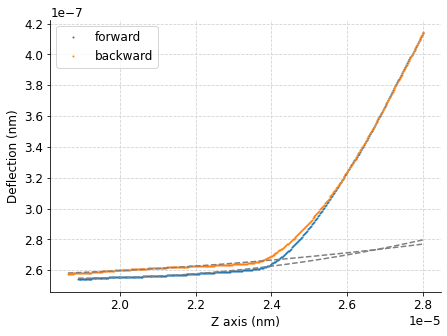

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
for mode in ("forward", "backward"):
    ax.plot(
        data[f"z-axis sensor_spec {mode}"],
        data[f"deflection_spec {mode}"],
        ".",
        markersize=2,
        label=mode,
    )
ax.legend()
ax.set_xlabel("Z axis (nm)")
ax.set_ylabel("Deflection (nm)")

plt.plot(z_axis_sensor_f, fitting_f(z_axis_sensor_f), '--', color='grey')
plt.plot(z_axis_sensor_b, fitting_b(z_axis_sensor_b), '--', color='grey')

Text(0, 0.5, 'Force(nN)')

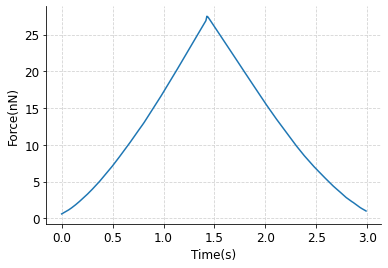

In [6]:
deflection_f = deflection_f-fitting_f(z_axis_sensor_f)
z_axis_sensor_f = np.delete(z_axis_sensor_f, np.where(z_axis_sensor_f<knee_point_f))
deflection_f = deflection_f[(len(deflection_f)-len(z_axis_sensor_f)):]

# plt.plot(z_axis_sensor_f, deflection_f)

deflection_b = deflection_b-fitting_b(z_axis_sensor_b)
z_axis_sensor_b = np.delete(z_axis_sensor_b, np.where(z_axis_sensor_b<knee_point_f))
deflection_b = deflection_b[(len(deflection_b)-len(z_axis_sensor_b)):]

# plt.plot(z_axis_sensor_b, deflection_b)

# Plotting AFM data in time domain
deflection = np.array([])
deflection = np.append(deflection_f, deflection_b[::-1])
z_axis_sensor = np.append(z_axis_sensor_f, z_axis_sensor_b[::-1])
time = np.arange(0, len(deflection)) * (10/1024)

fig, ax = plt.subplots(1, 1)
plt.plot(time, deflection*0.2*10**9)
ax.set_xlabel("Time(s)")
ax.set_ylabel("Force(nN)")


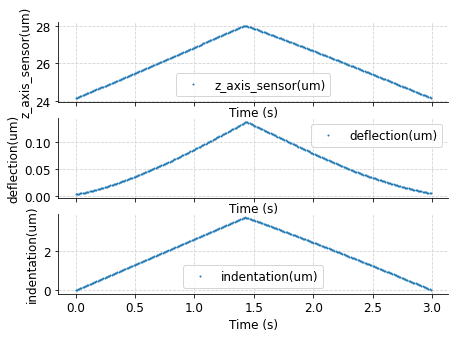

In [7]:
# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating
indentation = z_axis_sensor - deflection - knee_point_f

# Indentation - Time graph
fig, axes = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
labels = ("z_axis_sensor(um)", "deflection(um)", "indentation(um)")
y_data = (z_axis_sensor*10**6, deflection*10**6, indentation*10**6)
for ax, y, l in zip(axes, y_data, labels):
    ax.plot(
        time,
        y,
        ".",
        markersize=2,
        label=l,
        )
    ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(l)

In [ ]:
import numpy as np
from scipy.special import gamma, factorial

# Assumption : PLR model, conical tip, E0 = 1 kPa, gamma = 0.3, h = 2 um
pi = np.pi
theta = 
gamma_ = 0.3 # PLR model : gamma = 0(Elastic material), gamma = 1(Newtonian liquid)
v = indentation/time[len(deflection_f)]
t = time
t_max = np.arange(len(deflection_f))
t1 = t - 2**((1-gamma_)/2)(t-t_max)
t0 = 
# Approach
F = (8*np.tan(theta))*(2*v**2*t**2)(t/t0)**(-gamma_)*gamma(2)*gamma(1-gamma_)/(3*np.pi*gamma(3-gamma_))
